In [4]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, MobileNet, MobileNetV2, EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle, compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score
import mediapipe as mp

# Set random seed for reproducibility
SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# Enable inline plotting for Jupyter
%matplotlib inline

# Import Dataset KDEF & RAF-DB

### KDEF

In [6]:
DATASET_PATH = "D:/COMPETITION/GEMASTIK 2024/DATASET/KDEF"
image_size = (224,224)
batch_size = 4

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    validation_split=0.2
)
train_ds = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, "crop"),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=SEED_VALUE
)
ImageDataGenerator()

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH,"crop"),
    validation_split=0.2,
    label_mode = "categorical",
    subset="validation",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3692 images belonging to 7 classes.
Found 4612 files belonging to 7 classes.
Using 922 files for validation.


### RAF

In [3]:
DATASET_PATH = "D:/COMPETITION/GEMASTIK 2024/DATASET/RAF"
image_size = (224,224)
batch_size = 4

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    validation_split=0.2  
)
train_ds = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, "train"),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=SEED_VALUE
)
ImageDataGenerator()

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH,"train"),
    validation_split=0.2,
    label_mode = "categorical",
    subset="validation",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "test"),
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
)

Found 11182 images belonging to 7 classes.
Found 13974 files belonging to 7 classes.
Using 2794 files for validation.
Found 3068 files belonging to 7 classes.


In [7]:
NUM_CLASSES = 7  # Number of output classes for the classification task
IMG_SHAPE = (224, 224, 3)  # Shape of the input images (height, width, channels)
BATCH_SIZE = 32  # Batch size for training

SEED_VALUE = 1234  # Seed for reproducibility

# Training phase hyperparameters
TRAIN_EPOCH = 100  # Number of epochs for the initial training phase
TRAIN_LR_PATIENCE = 5  # Patience for learning rate reduction when validation accuracy plateaus
TRAIN_MIN_LR = 1e-6  # Minimum learning rate during training

TRAIN_LR = 0.001  # Initial learning rate
TRAIN_ES_PATIENCE = 5  # Patience for early stopping during training
TRAIN_DROPOUT = 0.1  # Dropout rate for the training phase

# Fine-tuning phase hyperparameters
FT_EPOCH = 500  # Number of epochs for fine-tuning phase
FT_LR = 1e-5  # Learning rate for fine-tuning phase
FT_LR_DECAY_STEP = 80.0  # Decay step for learning rate in fine-tuning
FT_LR_DECAY_RATE = 1  # Decay rate for learning rate in fine-tuning
FT_ES_PATIENCE = 20  # Patience for early stopping during fine-tuning
FT_DROPOUT = 0.2  # Dropout rate for the fine-tuning phase

# Early stopping and learning rate delta
ES_LR_MIN_DELTA = 0.003  # Minimum change in validation accuracy to consider improvement

In [8]:
# Define input layer and resize the input
input_layer = tf.keras.Input(shape=IMG_SHAPE, name='universal_input')
sample_resizing = tf.keras.layers.Resizing(224, 224, name="resize")

# Preprocessing and backbone (MobileNet)
preprocess_input = tf.keras.applications.mobilenet.preprocess_input
backbone = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
backbone.trainable = False  # Freeze MobileNet layers
base_model = tf.keras.Model(backbone.input, backbone.layers[-29].output, name='base_model')

# Self-attention and patch extraction layers
self_attention = tf.keras.layers.Attention(use_scale=True, name='attention')
patch_extraction = tf.keras.Sequential([
    tf.keras.layers.SeparableConv2D(256, kernel_size=4, strides=4, padding='same', activation='relu'),
    tf.keras.layers.SeparableConv2D(256, kernel_size=2, strides=2, padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu')
], name='patch_extraction')

# Set patch extraction layers to be trainable
for layer in patch_extraction.layers:
    layer.trainable = True

# Global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='gap')

# Pre-classification layers (dense + batch normalization + dropout)
pre_classification = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(TRAIN_DROPOUT)
], name='pre_classification')

# Final classification layer
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name='classification_head')

# Model architecture
inputs = input_layer
x = sample_resizing(inputs)  # Resize input
x = preprocess_input(x)  # Preprocess input for MobileNet
x = base_model(x, training=True)  # MobileNet backbone
x = patch_extraction(x)  # Patch extraction
x = global_average_layer(x)  # Global average pooling
x = tf.keras.layers.Dropout(TRAIN_DROPOUT)(x)  # Dropout
x = pre_classification(x)  # Pre-classification layers

# Reshape for attention layer
x = tf.keras.layers.Reshape((1, -1))(x)
x = self_attention([x, x])  # Self-attention
x = tf.keras.layers.Reshape((-1,))(x)  # Reshape back to original dimensions
outputs = prediction_layer(x)  # Final classification

# Build the model
model = tf.keras.Model(inputs, outputs, name='train-head')
model.summary()

Model: "train-head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ universal_input (InputLayer)  │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resize (Resizing)             │ (None, 224, 224, 3)       │               0 │ universal_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ true_divide (TrueDivide)      │ (None, 224, 224, 3)       │               0 │ resize[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ subtract (Subtract)           │ (None, 224, 224, 3)       │               0 │ true_divide[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ base_model (Functional)       │ (None, 14, 14, 512)       │         821,952 │ subtract[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ patch_extraction (Sequential) │ (None, 2, 2, 256)         │         272,128 │ base_model[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gap (GlobalAveragePooling2D)  │ (None, 256)               │               0 │ patch_extraction[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ gap[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pre_classification            │ (None, 64)                │          16,704 │ dropout_1[0][0]            │
│ (Sequential)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 64)             │               0 │ pre_classification[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention (Attention)         │ (None, 1, 64)             │               1 │ reshape[0][0],             │
│                               │                           │                 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 64)                │               0 │ attention[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classification_head (Dense)   │ (None, 7)                 │             455 │ reshape_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,111,240 (4.24 MB)

 Trainable params: 289,160 (1.10 MB)

 Non-trainable params: 822,080 (3.14 MB)

In [9]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=TRAIN_LR, global_clipnorm=3.0),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                           patience=TRAIN_ES_PATIENCE, 
                                                           min_delta=ES_LR_MIN_DELTA, 
                                                           restore_best_weights=True)

# Reduce learning rate when validation accuracy plateaus
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                              patience=TRAIN_LR_PATIENCE, 
                                                              verbose=0, 
                                                              min_delta=ES_LR_MIN_DELTA, 
                                                              min_lr=TRAIN_MIN_LR)

In [10]:
# Start timer
start_time = time.time()

# Model training with early stopping and learning rate reduction
loss = model.fit(train_ds, epochs=TRAIN_EPOCH, batch_size=BATCH_SIZE, 
                 validation_data=val_ds, verbose=1, 
                 callbacks=[early_stopping_callback, learning_rate_callback])

# End timer and calculate runtime
end_time = time.time()
runtime = end_time - start_time

# Print total runtime in seconds
print("Runtime: {:.4f} seconds".format(runtime))

Epoch 1/100


C:\Users\helio\anaconda3\envs\satria\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\helio\anaconda3\envs\satria\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


923/923 ━━━━━━━━━━━━━━━━━━━━ 57s 55ms/step - accuracy: 0.5474 - loss: 1.2909 - val_accuracy: 0.7451 - val_loss: 0.7107 - learning_rate: 0.0010
Epoch 2/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 48s 52ms/step - accuracy: 0.7801 - loss: 0.6940 - val_accuracy: 0.8319 - val_loss: 0.5571 - learning_rate: 0.0010
Epoch 3/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.8498 - loss: 0.5184 - val_accuracy: 0.8113 - val_loss: 0.5454 - learning_rate: 0.0010
Epoch 4/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 55s 59ms/step - accuracy: 0.8525 - loss: 0.4946 - val_accuracy: 0.9111 - val_loss: 0.2845 - learning_rate: 0.0010
Epoch 5/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 52s 56ms/step - accuracy: 0.8913 - loss: 0.3655 - val_accuracy: 0.9089 - val_loss: 0.3246 - learning_rate: 0.0010
Epoch 6/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - accuracy: 0.8781 - loss: 0.4324 - val_accuracy: 0.9035 - val_loss: 0.4152 - learning_rate: 0.0010
Epoch 7/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 53s 57ms/step - accuracy: 0.8972 - loss: 

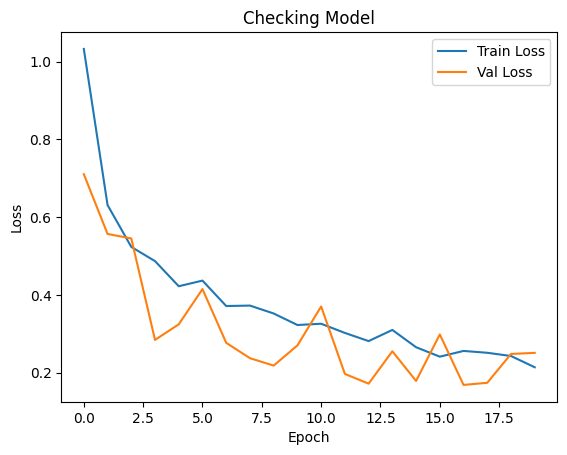

In [11]:
train_loss = loss.history['loss']
val_loss = loss.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.title("Checking Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# Evaluate the model on the validation set
test_loss, test_acc = model.evaluate(val_ds)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Get true and predicted labels from the validation set
y_true = []
y_pred = []
for X, y in val_ds:
    y_pred.extend(np.argmax(model.predict(X), axis=1))  # Get predicted labels
    y_true.extend(np.argmax(y, axis=1))  # Get true labels

# Calculate F1 score (weighted)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# Calculate precision (weighted)
precision = precision_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')

# Calculate recall (weighted)
recall = recall_score(y_true, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

# Calculate AUC (Area Under the Curve)
y_pred_prob = model.predict(val_ds)
auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')  # One-vs-Rest (OvR) for multiclass AUC
print(f'AUC: {auc:.4f}')

231/231 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9569 - loss: 0.1594
Test Loss: 0.1790
Test Accuracy: 0.9577


C:\Users\helio\anaconda3\envs\satria\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


C:\Users\helio\anaconda3\envs\satria\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

C:\Users\helio\anaconda3\envs\satria\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step
AUC: 0.5153


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1

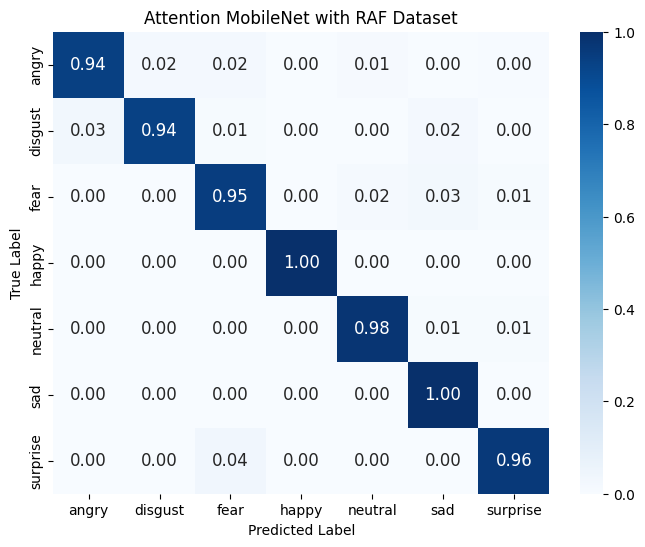

In [13]:
# Initialize lists for true and predicted labels
y_true = []
y_pred = []

# Loop through the validation dataset and predict labels
for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))  # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate accuracy percentage for each element in confusion matrix
accuracy_matrix = cm / cm.sum(axis=1, keepdims=True)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_matrix, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=val_ds.class_names, yticklabels=val_ds.class_names, annot_kws={"size": 12})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Attention MobileNet with RAF Dataset')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/

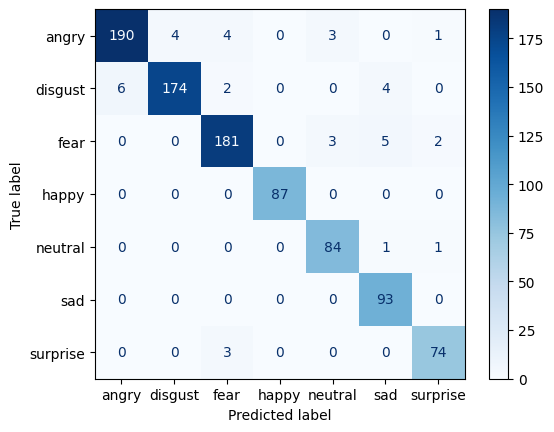

In [14]:
# Initialize lists for true and predicted labels
y_true = []
y_pred = []

# Loop through the validation dataset and predict labels
for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))  # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
# Save the entire model architecture, weights, and optimizer state to an .h5 file
model.save('expression_model.h5')  # Save model to .h5 file

# Save only the weights of the model to an .h5 file
model.save_weights('expression_model.weights.h5')  # Save weights to .h5 file

# GRAD-CAM (Class Activation Map)

C:\Users\helio\AppData\Local\Temp\ipykernel_33900\1684985528.py:52: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNet(weights='imagenet', include_top=False)


Processing image for class 'happy'...


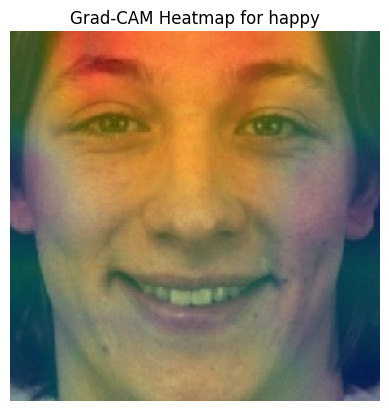

Processing image for class 'sad'...


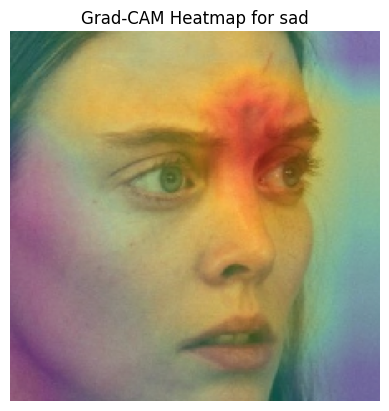

Processing image for class 'disgust'...


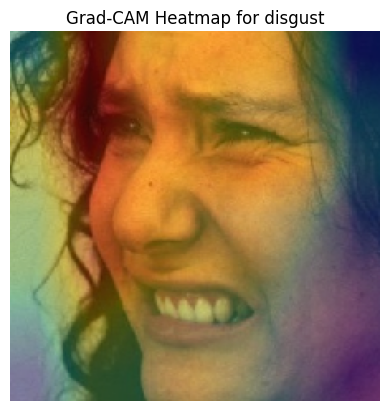

Processing image for class 'angry'...


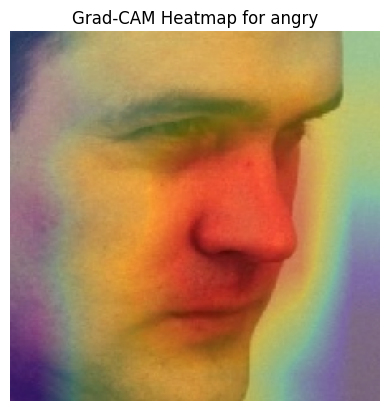

Processing image for class 'fear'...


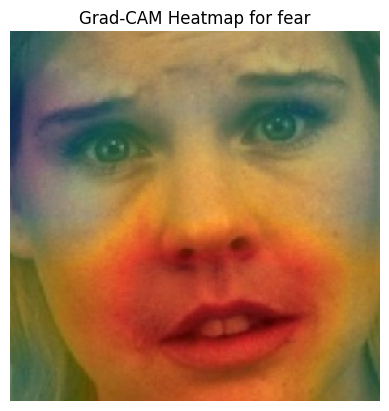

Processing image for class 'surprise'...


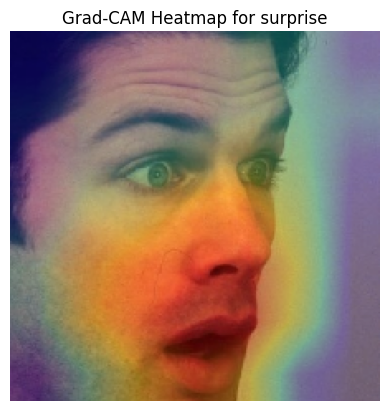

Processing image for class 'neutral'...


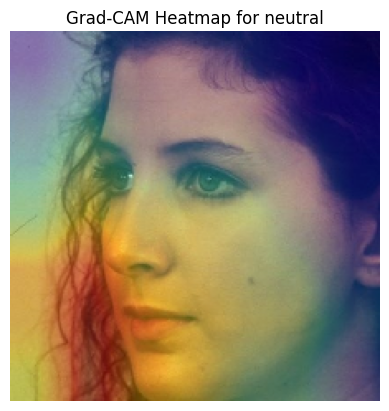

In [21]:
def get_gradcam(model, img_array, layer_name, class_idx):
    # Create a model that outputs both the selected layer and model predictions
    grad_model = Model(
        inputs=model.input,  # Use model.input for the input of the model
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Record the gradients of the output with respect to the selected layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]  # Loss is the predicted score for the target class

    # Compute the gradients of the loss w.r.t. the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)[0]

    # Filter out only positive gradients (guided backpropagation)
    guided_grads = (
        tf.cast(conv_outputs > 0, "float32")  # Consider only positive activation outputs
        * tf.cast(grads > 0, "float32")       # Consider only positive gradients
        * grads
    )

    # Extract the first element in the batch
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    # Calculate weights by averaging the gradients
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Create the Grad-CAM by weighting the filters
    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    # Apply ReLU to keep positive values and normalize the heatmap
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    # Resize heatmap to the input image size
    cam = tf.image.resize(cam[..., tf.newaxis], img_array.shape[1:3]).numpy()
    cam = np.squeeze(cam)
    return cam


def overlay_gradcam(img, cam, alpha=0.4, colormap='jet'):
    # Generate the heatmap using the selected colormap
    heatmap = plt.get_cmap(colormap)(cam)  # Create heatmap from Grad-CAM
    heatmap = np.uint8(255 * heatmap[..., :3])  # Convert to RGB format

    # Resize the heatmap to match the input image size
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1])).numpy()

    # Superimpose the heatmap on the original image with the specified transparency (alpha)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img / np.max(superimposed_img) * 255)  # Normalize to uint8
    return superimposed_img


# Load MobileNet model with pre-trained ImageNet weights
model = MobileNet(weights='imagenet', include_top=False)

# Load the dataset path and image size
DATASET_PATH = "D:/COMPETITION/GEMASTIK 2024/DATASET/KDEF"
image_size = (224, 224)
batch_size = 1  # Set batch size to 1 for individual prediction

# Define the class labels
class_labels = ["happy", "sad", "disgust", "angry", "fear", "surprise", "neutral"]

# Iterate through each class and predict one random image from each class
for class_name in class_labels:
    print(f"Processing image for class '{class_name}'...")
    
    # Load a random image from the class directory
    class_dir = os.path.join(DATASET_PATH, "crop", class_name)
    img_name = random.choice(os.listdir(class_dir))  # Choose a random image
    img_path = os.path.join(class_dir, img_name)
    
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)

    # Get the true label index
    true_label = class_labels.index(class_name)

    # Generate Grad-CAM for the selected image and class
    layer_name = 'conv_pw_13_relu'  # Select a deep convolutional layer from MobileNet
    cam = get_gradcam(model, img_array, layer_name=layer_name, class_idx=true_label)

    # Overlay the Grad-CAM heatmap on the original image
    img = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
    superimposed_img = overlay_gradcam(img, cam)

    # Display the image with the Grad-CAM overlay
    plt.imshow(superimposed_img)
    plt.axis('off')  # Hide axis for better visualization
    plt.title(f'Grad-CAM Heatmap for {class_name}')
    plt.show()